In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [ ]:
#Read data from google drive
df = pd.read_csv("/content/drive/MyDrive/dataset_mood_smartphone.csv", parse_dates=['time'])
# Extract date from timestamp
df['date'] = df['time'].dt.date
df

,Unnamed: 0,id,time,variable,value,date
0,1,AS14.01,2014-02-26 13:00:00.000,mood,6.000,2014-02-26
1,2,AS14.01,2014-02-26 15:00:00.000,mood,6.000,2014-02-26
2,3,AS14.01,2014-02-26 18:00:00.000,mood,6.000,2014-02-26
3,4,AS14.01,2014-02-26 21:00:00.000,mood,7.000,2014-02-26
4,5,AS14.01,2014-02-27 09:00:00.000,mood,6.000,2014-02-27
...,...,...,...,...,...,...
376907,2770399,AS14.30,2014-04-11 07:51:16.948,appCat.weather,8.032,2014-04-11
376908,2772465,AS14.30,2014-04-19 11:00:32.747,appCat.weather,3.008,2014-04-19
376909,2774026,AS14.30,2014-04-26 10:19:07.434,appCat.weather,7.026,2014-04-26
376910,2774133,AS14.30,2014-04-27 00:44:48.450,appCat.weather,23.033,2014-04-27


In [ ]:
# Pivot to wide format (one row per ID-date with variables as columns, day-level aggregation)
pivot_df = df.pivot_table(
    index=['id', 'date'],
    columns='variable',
    values='value'
).reset_index().fillna(0)
pivot_df

variable,id,date,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,...,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms
0,AS14.01,2014-02-17,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0,0.000000,0.0
1,AS14.01,2014-02-18,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0,0.000000,0.0
2,AS14.01,2014-02-19,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0,0.000000,1.0
3,AS14.01,2014-02-20,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0,0.000000,1.0
4,AS14.01,2014-02-21,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1968,AS14.33,2014-05-27,0.012704,8.545776,59.382943,62.347000,0.0,0.0,0.000000,17.835750,...,0.000000,0.000000,18.724333,0.0,1.0,-0.600000,0.4,6.2,113.607750,1.0
1969,AS14.33,2014-05-28,0.103301,9.590398,37.238750,43.907571,0.0,0.0,44.738625,27.891895,...,0.000000,0.000000,5.111000,0.0,1.0,0.000000,1.2,8.2,113.657683,1.0
1970,AS14.33,2014-05-29,0.169354,6.452161,54.388125,68.369000,0.0,0.0,0.000000,9.734000,...,0.939000,0.000000,1.599500,0.0,1.0,-1.333333,1.0,7.0,118.978033,1.0
1971,AS14.33,2014-05-30,0.192901,14.776845,46.412278,37.174286,0.0,0.0,0.000000,10.522000,...,37.594571,2.690667,15.521667,0.0,1.0,-0.800000,-0.4,6.8,86.342245,0.0


##Feature eng.

In [ ]:
# Forward fill missing values (within each ID's data)
pivot_df['date'] = pivot_df['date'].apply(lambda date: date.toordinal())

# Add all variables
expected_vars = [
    'mood', 'circumplex.arousal', 'circumplex.valence', 'activity',
    'screen', 'call', 'sms', 'appCat.builtin', 'appCat.communication',
    'appCat.entertainment', 'appCat.finance', 'appCat.game', 'appCat.office',
    'appCat.other', 'appCat.social', 'appCat.travel', 'appCat.unknown',
    'appCat.utilities', 'appCat.weather'
]

#filling any missing variable values with 0
for var in expected_vars:
    if var not in pivot_df.columns:
        pivot_df[var] = 0

In [ ]:
# Create target (next day's mood)
pivot_df['target_mood'] = pivot_df.groupby('id')['mood'].shift(-1)
pivot_df = pivot_df.dropna(subset=['target_mood'])

# Define mood classes: bad (1-3), normal (4-7), good (8-10)
pivot_df['mood_class'] = pd.cut(pivot_df['target_mood'],
                                bins=[0, 3, 7, 10],
                                labels=['bad', 'normal', 'good'],
                                include_lowest=True,
                                right=False)
#pivot_df = pivot_df.dropna(subset=['mood_class'])

<ipython-input-29-65d24c8ec297>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_df['mood_class'] = pd.cut(pivot_df['target_mood'],


In [ ]:
#pivot_df = pivot_df.drop(['target_mood'], axis=1)
#pivot_df = pivot_df.drop(['mood'], axis=1)
pivot_df

variable,id,date,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,...,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,screen,sms,mood_class
0,AS14.01,735281,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.000000,0.0,bad
1,AS14.01,735282,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.000000,0.0,bad
2,AS14.01,735283,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.000000,1.0,bad
3,AS14.01,735284,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.000000,1.0,bad
4,AS14.01,735285,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,1.0,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1967,AS14.33,735379,0.115201,7.711316,34.320472,68.876900,0.0,0.0,130.530000,16.845500,...,0.000000,0.000000,0.000000,0.0,1.0,-0.400000,0.0,300.399810,1.0,normal
1968,AS14.33,735380,0.012704,8.545776,59.382943,62.347000,0.0,0.0,0.000000,17.835750,...,0.000000,0.000000,18.724333,0.0,1.0,-0.600000,0.4,113.607750,1.0,good
1969,AS14.33,735381,0.103301,9.590398,37.238750,43.907571,0.0,0.0,44.738625,27.891895,...,0.000000,0.000000,5.111000,0.0,1.0,0.000000,1.2,113.657683,1.0,good
1970,AS14.33,735382,0.169354,6.452161,54.388125,68.369000,0.0,0.0,0.000000,9.734000,...,0.939000,0.000000,1.599500,0.0,1.0,-1.333333,1.0,118.978033,1.0,normal


In [ ]:
X = pivot_df.iloc[:, 1:-1].values
y = pivot_df.iloc[:, -1].values

# Train-test split (stratified by class)
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
from sklearn.metrics import classification_report

# Initialize and train classifier
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         bad       0.97      0.95      0.96       136
        good       0.65      0.84      0.73       156
      normal       0.57      0.32      0.41        98

    accuracy                           0.75       390
   macro avg       0.73      0.70      0.70       390
weighted avg       0.74      0.75      0.73       390



##Hyperparameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

param_grid = {
    'n_estimators': [50, 100, 200, 300],       # Number of trees
    'max_depth': [None, 3, 5, 7, 10],          # Maximum tree depth
    'min_samples_split': [2, 3, 5],          # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 3, 5],           # Minimum samples at a leaf node
    'max_features': ['auto', 'sqrt', 'log2', None]
}

In [ ]:
# Use stratified cross-validation for imbalanced classes
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1_weighted',  # Use weighted F1-score for class imbalance
    cv=cv,
    verbose=2,             # Print progress
    n_jobs=-1              # Use all CPU cores
)

# Fit to training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
1200 fits failed out of a total of 4800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
134 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 3, 5, 7, 10],
                         'max_features': ['auto', 'sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 3, 5],
                         'min_samples_split': [2, 3, 5],
                         'n_estimators': [50, 100, 200, 300]},
             scoring='f1_weighted', verbose=2)

In [ ]:
# Get best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get best model
best_clf = grid_search.best_estimator_

Best Hyperparameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 50}


In [ ]:
# Predict on test set
y_pred = best_clf.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         bad       0.96      0.96      0.96       136
        good       0.69      0.83      0.76       156
      normal       0.64      0.43      0.51        98

    accuracy                           0.78       390
   macro avg       0.76      0.74      0.74       390
weighted avg       0.77      0.78      0.77       390



In [ ]:
# Feature importance
importance = pd.DataFrame({'feature': pivot_df.iloc[:, 1:-1].columns, 'importance': best_clf.feature_importances_})
print(importance.sort_values('importance', ascending=False))

                 feature  importance
17                screen    0.460978
16    circumplex.valence    0.123545
2         appCat.builtin    0.076578
0                   date    0.064950
1               activity    0.043852
3   appCat.communication    0.039317
4   appCat.entertainment    0.037006
8           appCat.other    0.033505
9          appCat.social    0.030167
15    circumplex.arousal    0.024718
10         appCat.travel    0.012700
12      appCat.utilities    0.011856
6            appCat.game    0.007690
18                   sms    0.007297
7          appCat.office    0.006050
11        appCat.unknown    0.005376
14                  call    0.005346
5         appCat.finance    0.005047
13        appCat.weather    0.004023


In [ ]:
importances = best_clf.feature_importances_
feature_names = pivot_df.iloc[:, 1:-1].columns

# Create a DataFrame for easy sorting
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

<ipython-input-64-e1466bf9cc4c>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df,


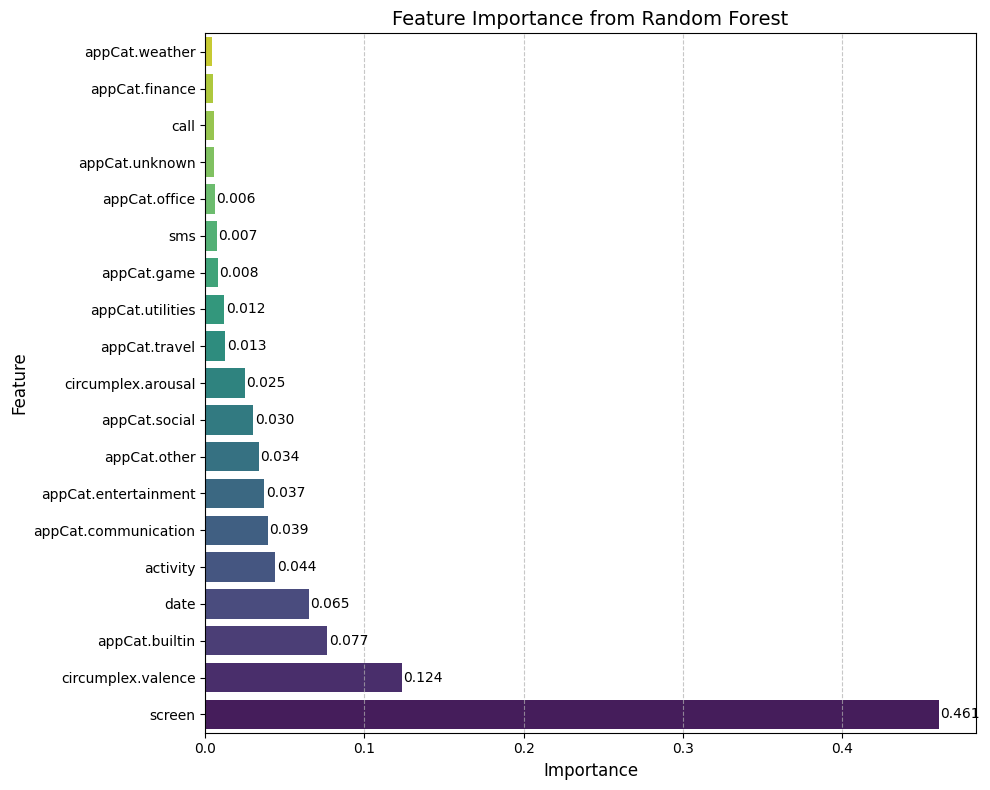

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
plt.title("Feature Importance from Random Forest", fontsize=14)
bars = plt.barh(
    feature_importance_df['Feature'][:15],  # Show top 15 features
    feature_importance_df['Importance'][:15],
    color='skyblue'
)

# Add importance values to bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', ha='left', va='center')

sns.barplot(x='Importance', y='Feature', data=feature_importance_df,
            palette='viridis')

plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.gca().invert_yaxis()  # Show most important at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<ipython-input-62-268f8c36c04f>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df,


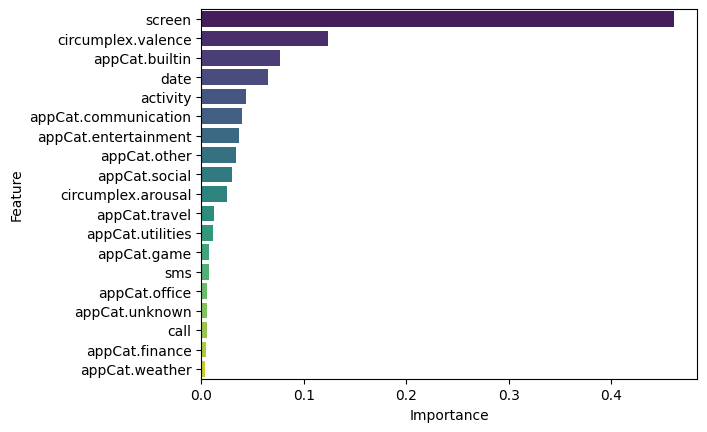

In [ ]:


plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')